In [6]:
import numpy as np
import pandas as pd
from sklearn.metrics import precision_recall_curve,roc_curve, roc_auc_score, RocCurveDisplay, auc,average_precision_score,PrecisionRecallDisplay,precision_score,recall_score
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

# For making pdfs that are easily editable in illustrator
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
plt.rcParams["font.family"] = "Helvetica"

# Part one: Making a table summarizing, GT, Mahala, Mahala Boot, and regression L1 for all run, scheme,etc

In [7]:
data_read_path = "../../../../cell_painting_data_lock/4_CS_OBJECTS_median_aggregated/"
data_read_suffix = "_PCH_rd_OG316"
save_path = "data_tables/"

# regression_read_path = "../../../../Ivy/decon_out/09272021_PCH_rd_OG316_pca_decon_out/"
regression_read_path = "../../regression_deconvolution_December2021/decon_out/raw_rd_OG316_raw_decon_out/"

## On the Emprical Covariance stuff

### GT

In [8]:
# Load in the set of 316 drugs used in the screens
cs_drugs = pd.read_csv("../mahalanobis_calcs_on_compressed_15Nov2021/mahala_calculations/CS_run1_2.0x5.0r_randommahala_table.csv").Metadata_perturbation.values

gt_mahala = pd.read_csv("../../../../BEM/Manu_analysis/2_OG316_analysis/GT316_mahala_empirical_table.csv")

# Need to update the name of one drug with a weird name that got annotated in two ways
gt_mahala.Metadata_perturbation.values[gt_mahala.Metadata_perturbation.values=='Methyldopa Sesquihydrate (L-A-Methyl-Dopa Sesquihyrate)']='Methyldopa Sesquihydrate (L-_-Methyl-Dopa Sesquihyrate)'

# Filter down to OG 316 and remove the DMSO wells
gt_mahala = gt_mahala.loc[gt_mahala.Metadata_perturbation.isin(cs_drugs)]
gt_mahala = gt_mahala.loc[gt_mahala.Metadata_perturbation!="DMSO"]

# rename columns where necesseary
gt_mahala.columns = ['Metadata_perturbation','gt_mahalanobis','gt_signif_mahala']
gt_mahala.index = gt_mahala.Metadata_perturbation.values
gt_mahala.sort_index(inplace=True)

num_gt_sig = sum(gt_mahala.gt_signif_mahala=='True')

# Add in indciates of top num_gt_sig (signif) and 32 (10% of library drugs)
gt_mahala_top_num_gt_sig_drugs = gt_mahala.sort_values(by=['gt_mahalanobis'],ascending=False).index.values[0:num_gt_sig]
gt_mahala['gt_mahalanobis_topnum_gt_sig'] =  np.isin(gt_mahala.index.values,gt_mahala_top_num_gt_sig_drugs)
gt_mahala_top_32_drugs = gt_mahala.sort_values(by=['gt_mahalanobis'],ascending=False).index.values[0:32]
gt_mahala['gt_mahalanobis_top32'] =  np.isin(gt_mahala.index.values,gt_mahala_top_32_drugs)
gt_mahala_top_5_drugs = gt_mahala.sort_values(by=['gt_mahalanobis'],ascending=False).index.values[0:5]
gt_mahala['gt_mahalanobis_top5'] =  np.isin(gt_mahala.index.values,gt_mahala_top_5_drugs)
gt_mahala_top_10_drugs = gt_mahala.sort_values(by=['gt_mahalanobis'],ascending=False).index.values[0:10]
gt_mahala['gt_mahalanobis_top10'] =  np.isin(gt_mahala.index.values,gt_mahala_top_10_drugs)

### CS

In [9]:
bootstrap_percentile = 5 # using the 5th percentile of the adjust mahalanobis value as the "adjusted mahalanobis"

for run in ['CS_run1','CS_run2','CS_run3']:

    metadata = pd.read_csv(data_read_path+run+data_read_suffix+"_metadata.csv",index_col=0)
     # Layout all of the compression schemes
    compression_methods = metadata.groupby(['Metadata_compression','Metadata_replicates','Metadata_perturbation','Metadata_Plate']).size().reset_index().rename(columns={0:''})
    compression_methods = compression_methods.loc[np.isin(compression_methods['Metadata_perturbation'],['random','random1','random2'])]
    compression_methods.to_csv(run+"_compression_methods.csv",index=False)

    for i in range(compression_methods.shape[0]):

        compression = compression_methods['Metadata_compression'].iloc[i]
        replicates = compression_methods['Metadata_replicates'].iloc[i]
        scheme = compression_methods['Metadata_perturbation'].iloc[i]
        
        if run =='CS_run3' and compression == 32.0:
            compression = 32
            replicates = 5

        cs_mahala = pd.read_csv("../mahalanobis_calcs_on_compressed_15Nov2021/mahala_calculations/"+run+"_"+str(compression)+"x"+str(replicates)+"r"+"_"+scheme+"mahala_table_DMSO_1e7_samples_17Nov2021_empiricalcov.csv",index_col=0)
        cs_mahala = cs_mahala.iloc[:,0:3]
        cs_mahala.columns = ['Metadata_perturbation','cs_mahalanobis','cs_signif_mahala',]
        cs_mahala = cs_mahala[cs_mahala.Metadata_perturbation!="DMSO"]
        cs_mahala.index = cs_mahala.Metadata_perturbation.values

        cs_mahala_top_num_gt_sig_drugs = cs_mahala.sort_values(by=['cs_mahalanobis'],ascending=False).index.values[0:num_gt_sig]
        cs_mahala['cs_mahalanobis_topnum_gt_sig'] =  np.isin(cs_mahala.index.values,cs_mahala_top_num_gt_sig_drugs)
        cs_mahala_top_32_drugs = cs_mahala.sort_values(by=['cs_mahalanobis'],ascending=False).index.values[0:32]
        cs_mahala['cs_mahalanobis_top32'] =  np.isin(cs_mahala.index.values,cs_mahala_top_32_drugs)
        cs_mahala_top_5_drugs = cs_mahala.sort_values(by=['cs_mahalanobis'],ascending=False).index.values[0:5]
        cs_mahala['cs_mahalanobis_top5'] =  np.isin(cs_mahala.index.values,cs_mahala_top_5_drugs)
        cs_mahala_top_10_drugs = cs_mahala.sort_values(by=['cs_mahalanobis'],ascending=False).index.values[0:10]
        cs_mahala['cs_mahalanobis_top10'] =  np.isin(cs_mahala.index.values,cs_mahala_top_10_drugs)


        bootstrap_values = np.load("../mahalanobis_calcs_on_compressed_15Nov2021/mahala_calculations/"+run+"_"+str(compression)+"x"+str(replicates)+"r"+"_"+scheme+"mahalas_resampled_DMSO_1e7_samples_17Nov2021_empiricalcov.npy")
        mahalas_boot = np.zeros(bootstrap_values.shape[0])
        for m in range(bootstrap_values.shape[0]):
            mahalas_boot[m] = np.percentile(bootstrap_values[m,:],bootstrap_percentile)
        cs_mahala['cs_mahalanobis_bootstrap'] = mahalas_boot

        cs_mahala_top_num_gt_sig_drugs = cs_mahala.sort_values(by=['cs_mahalanobis_bootstrap'],ascending=False).index.values[0:num_gt_sig]
        cs_mahala['cs_mahalanobis_bootstrap_topnum_gt_sig'] =  np.isin(cs_mahala.index.values,cs_mahala_top_num_gt_sig_drugs)
        cs_mahala_top_32_drugs = cs_mahala.sort_values(by=['cs_mahalanobis_bootstrap'],ascending=False).index.values[0:32]
        cs_mahala['cs_mahalanobis_bootstrap_top32'] =  np.isin(cs_mahala.index.values,cs_mahala_top_32_drugs)

        cs_mahala_top_5_drugs = cs_mahala.sort_values(by=['cs_mahalanobis_bootstrap'],ascending=False).index.values[0:5]
        cs_mahala['cs_mahalanobis_bootstrap_top5'] =  np.isin(cs_mahala.index.values,cs_mahala_top_5_drugs)
        cs_mahala_top_10_drugs = cs_mahala.sort_values(by=['cs_mahalanobis_bootstrap'],ascending=False).index.values[0:10]
        cs_mahala['cs_mahalanobis_bootstrap_top10'] =  np.isin(cs_mahala.index.values,cs_mahala_top_10_drugs)

        if run =='CS_run3' and compression == 32:
            compression = 32.0
            replicates = 5.0
        
        model_coef = pd.read_csv(regression_read_path +run+"_"+str(compression)+"x_"+str(replicates)+"r"+"_"+scheme+"_permute_model_coef.csv",index_col=0)
        model_coef.index.rename('Metadata_perturbation',inplace=True)
        model_coef = model_coef.loc[model_coef.index.values!="DMSO"]
        model_coef.sort_index(inplace=True)
        model_coef['regression_l1_norm'] = np.abs(model_coef).sum(1)

        model_coef_top_num_gt_sig_drugs = model_coef.sort_values(by=['regression_l1_norm'],ascending=False).index.values[0:num_gt_sig]
        model_coef['regression_l1_norm_topnum_gt_sig'] =  np.isin(model_coef.index.values,model_coef_top_num_gt_sig_drugs)
        model_coef_top_32_drugs = model_coef.sort_values(by=['regression_l1_norm'],ascending=False).index.values[0:32]
        model_coef['regression_l1_norm_top32'] =  np.isin(model_coef.index.values,model_coef_top_32_drugs)

        model_coef_top_5_drugs = model_coef.sort_values(by=['regression_l1_norm'],ascending=False).index.values[0:5]
        model_coef['regression_l1_norm_top5'] =  np.isin(model_coef.index.values,model_coef_top_5_drugs)
        model_coef_top_10_drugs = model_coef.sort_values(by=['regression_l1_norm'],ascending=False).index.values[0:10]
        model_coef['regression_l1_norm_top10'] =  np.isin(model_coef.index.values,model_coef_top_10_drugs)

        model_coef_no_permute = pd.read_csv(regression_read_path +run+"_"+str(compression)+"x_"+str(replicates)+"r"+"_"+scheme+"_model_coef.csv",index_col=0)
        model_coef_no_permute.index.rename('Metadata_perturbation',inplace=True)
        model_coef_no_permute = model_coef_no_permute.loc[model_coef_no_permute.index.values!="DMSO"]
        model_coef_no_permute.sort_index(inplace=True)
        model_coef_no_permute['no_permute_regression_l1_norm'] = np.abs(model_coef_no_permute).sum(1)


        if i ==0 and run =='CS_run1':
            mahalanobis_regression_comparison = pd.concat([gt_mahala,cs_mahala,model_coef.regression_l1_norm,model_coef_no_permute.no_permute_regression_l1_norm,
                                                          model_coef.regression_l1_norm_topnum_gt_sig,
                                                          model_coef.regression_l1_norm_top32,
                                                          model_coef.regression_l1_norm_top10,
                                                          model_coef.regression_l1_norm_top5],axis=1,sort=True)
            mahalanobis_regression_comparison['Metadata_run'] = run
            mahalanobis_regression_comparison['Metadata_compression'] = compression
            mahalanobis_regression_comparison['Metadata_replicates'] = replicates
            mahalanobis_regression_comparison['Metadata_optimization'] = scheme
        else:
            temp = pd.concat([gt_mahala,cs_mahala,model_coef.regression_l1_norm,model_coef_no_permute.no_permute_regression_l1_norm,
                                                          model_coef.regression_l1_norm_topnum_gt_sig,
                                                          model_coef.regression_l1_norm_top32,
                                                          model_coef.regression_l1_norm_top10,
                                                          model_coef.regression_l1_norm_top5],axis=1,sort=True)
            temp['Metadata_run'] = run
            temp['Metadata_compression'] = compression
            temp['Metadata_replicates'] = replicates
            temp['Metadata_optimization'] = scheme
            mahalanobis_regression_comparison = pd.concat([mahalanobis_regression_comparison,temp])



mahalanobis_regression_comparison.drop(labels=["Metadata_perturbation"],axis=1,inplace=True)
mahalanobis_regression_comparison.to_csv("mahalanobis_plusMinus_bootstrap_and_regressionL1_empiricalcov_with_permute_raw_reg.csv")



In [10]:
all_compression_methods = mahalanobis_regression_comparison.groupby(['Metadata_run','Metadata_compression','Metadata_replicates','Metadata_optimization']).size().reset_index().rename(columns={0:''})
all_compression_methods.to_csv("all_compression_methods.csv",index=False)

In [11]:
1

1

# Part two: Making regression & Classification plots

Plots to make

- Regression scatter plots
    - CS mahala vs gt mahala
    - l1 norm regression vs gt mahala
- AUC & Precision recall plots (requires more plannign than my 7 pm brain can do)
    - For 

## Making regression plots

#### First lets calculate all of the pearson correlations and save those as a csv

In [13]:
# # With Mincovdet
# mahalanobis_regression_comparison = pd.read_csv("mahalanobis_plusMinus_bootstrap_and_regressionL1_mincovdet.csv")

# gt_cs_naive_mahala_cor = []
# gt_cs_boot_mahala_cor = []
# gt_mahala_cs_reg_corr = []
# for i in range(all_compression_methods.shape[0]):
#     run = all_compression_methods.Metadata_run.iloc[i]
#     compression = all_compression_methods.Metadata_compression.iloc[i]
#     replicates = all_compression_methods.Metadata_replicates.iloc[i]
#     scheme = all_compression_methods.Metadata_optimization.iloc[i]
#     data =mahalanobis_regression_comparison.loc[(mahalanobis_regression_comparison.Metadata_run==run)&
#                                          (mahalanobis_regression_comparison.Metadata_compression==compression)&
#                                          (mahalanobis_regression_comparison.Metadata_replicates==replicates)&
#                                          (mahalanobis_regression_comparison.Metadata_optimization==scheme)]

#     gt_cs_naive_mahala_cor.append(pearsonr(data.gt_mahalanobis,data.cs_mahalanobis)[0])
#     gt_cs_boot_mahala_cor.append(pearsonr(data.gt_mahalanobis,data.cs_mahalanobis_bootstrap)[0])
#     gt_mahala_cs_reg_corr.append(pearsonr(data.gt_mahalanobis,data.regression_l1_norm)[0])

# all_compression_methods['gt_mahala_vs_cs_mahala_pearson'] = gt_cs_naive_mahala_cor
# all_compression_methods['gt_mahala_vs_cs_boot_mahala_pearson'] = gt_cs_boot_mahala_cor 
# all_compression_methods['gt_mahala_vs_cs_regression_l1_norm'] = gt_mahala_cs_reg_corr
# all_compression_methods.to_csv("CS_all_pearsons_gt_mahala_vs_mahala_mahalaBoot_regL1_mincovdet.csv",index=False)

# On the empirical covariance stuff
mahalanobis_regression_comparison = pd.read_csv("mahalanobis_plusMinus_bootstrap_and_regressionL1_empiricalcov_with_permute_raw_reg.csv")

gt_cs_naive_mahala_cor = []
gt_cs_boot_mahala_cor = []
gt_mahala_cs_reg_corr = []
gt_mahala_cs_no_permute_corr = []
for i in range(all_compression_methods.shape[0]):
    run = all_compression_methods.Metadata_run.iloc[i]
    compression = all_compression_methods.Metadata_compression.iloc[i]
    replicates = all_compression_methods.Metadata_replicates.iloc[i]
    scheme = all_compression_methods.Metadata_optimization.iloc[i]
    data =mahalanobis_regression_comparison.loc[(mahalanobis_regression_comparison.Metadata_run==run)&
                                         (mahalanobis_regression_comparison.Metadata_compression==compression)&
                                         (mahalanobis_regression_comparison.Metadata_replicates==replicates)&
                                         (mahalanobis_regression_comparison.Metadata_optimization==scheme)]

    gt_cs_naive_mahala_cor.append(pearsonr(data.gt_mahalanobis,data.cs_mahalanobis)[0])
    gt_cs_boot_mahala_cor.append(pearsonr(data.gt_mahalanobis,data.cs_mahalanobis_bootstrap)[0])
    gt_mahala_cs_reg_corr.append(pearsonr(data.gt_mahalanobis,data.regression_l1_norm)[0])
    gt_mahala_cs_no_permute_corr.append(pearsonr(data.gt_mahalanobis,data.no_permute_regression_l1_norm)[0])

all_compression_methods['gt_mahala_vs_cs_mahala_pearson'] = gt_cs_naive_mahala_cor
all_compression_methods['gt_mahala_vs_cs_boot_mahala_pearson'] = gt_cs_boot_mahala_cor 
all_compression_methods['gt_mahala_vs_cs_regression_l1_norm'] = gt_mahala_cs_reg_corr
all_compression_methods['gt_mahala_vs_cs_no_permute_regression_l1_norm'] = gt_mahala_cs_no_permute_corr
all_compression_methods.to_csv("CS_all_pearsons_gt_mahala_vs_mahala_mahalaBoot_regL1_empiricalcov_with_permute_raw_reg.csv",index=False)

In [14]:
1

1

#### Then lets export things to R and do the plotting there bc R is better for that shit

# Part three making classification plots

In [17]:
# Plotting function for assess deconvolution results & for returning
# the area under the ROC curve and the average precisiion from the PR curve

def roc_and_precision_recall_curve(y_true,y_test,run,scheme,plot=False):
    
    ### ROC curve
    # Compute the AUC score 
    fpr, tpr, thresholds = roc_curve(y_true, y_test)
    roc_auc = roc_auc_score(y_true, y_test)
    # print('AUC: %.3f' % roc_auc)
    if plot:
        roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,estimator_name=run+": " + scheme)
        roc_display.plot()
        plt.title("ROC")

    ### Precision-Recall curve
    # calculate precision-recall curve
    precision, recall, thresholds = precision_recall_curve(y_true,
                                                          y_test)
    # calculate precision-recall AUC
    avg_precision = average_precision_score(y_true,y_test)
    
    if plot:
        pr_auc = auc(recall, precision)
        pr_display = PrecisionRecallDisplay(precision=precision, recall=recall,average_precision=avg_precision,
                                      estimator_name=run+": " + scheme)
        pr_display.plot()
        plt.title("Precision Recall")
    
    return roc_auc, avg_precision

In [18]:
# Plotting function for assess deconvolution results & for returning
# the area under the ROC curve and the average precisiion from the PR curve

def precision_and_recall(y_true,y_test,run,scheme,plot=False):

    ### Precision-Recall curve
    # calculate precision-recall curve
    precision = precision_score(y_true,y_test)
    recall = recall_score(y_true,y_test)
    
    return precision, recall

## Calculating the fraction of the true hits recovered

In [9]:
all_compression_methods = pd.read_csv("all_compression_methods.csv")
mahalanobis_regression_comparison = pd.read_csv("mahalanobis_plusMinus_bootstrap_and_regressionL1_empiricalcov_with_permute.csv")
top5_10_mahala =[]
top5_10_boot =[]
top5_10_reg =[]

top5_32_mahala =[]
top5_32_boot =[]
top5_32_reg =[]

top10_32_mahala =[]
top10_32_boot =[]
top10_32_reg =[]

# LET"S LEVERAGE THE FACT THAT WE ARE SAVING SAMPLES!!!!!!!

for i in range(all_compression_methods.shape[0]):

    run = all_compression_methods.Metadata_run.iloc[i]
    compression = all_compression_methods.Metadata_compression.iloc[i]
    replicates = all_compression_methods.Metadata_replicates.iloc[i]
    scheme = all_compression_methods.Metadata_optimization.iloc[i]
    data =mahalanobis_regression_comparison.loc[(mahalanobis_regression_comparison.Metadata_run==run)&
                                         (mahalanobis_regression_comparison.Metadata_compression==compression)&
                                         (mahalanobis_regression_comparison.Metadata_replicates==replicates)&
                                         (mahalanobis_regression_comparison.Metadata_optimization==scheme)]

    top5_10_mahala.append(sum(np.logical_and(data['gt_mahalanobis_top5'],data['cs_mahalanobis_top10']))/5)
    top5_10_boot.append(sum(np.logical_and(data['gt_mahalanobis_top5'],data['cs_mahalanobis_bootstrap_top10']))/5)
    top5_10_reg.append(sum(np.logical_and(data['gt_mahalanobis_top5'],data['regression_l1_norm_top10']))/5)

    top5_32_mahala.append(sum(np.logical_and(data['gt_mahalanobis_top5'],data['cs_mahalanobis_top32']))/5)
    top5_32_boot.append(sum(np.logical_and(data['gt_mahalanobis_top5'],data['cs_mahalanobis_bootstrap_top32']))/5)
    top5_32_reg.append(sum(np.logical_and(data['gt_mahalanobis_top5'],data['regression_l1_norm_top32']))/5)

    top10_32_mahala.append(sum(np.logical_and(data['gt_mahalanobis_top10'],data['cs_mahalanobis_top32']))/10)
    top10_32_boot.append(sum(np.logical_and(data['gt_mahalanobis_top10'],data['cs_mahalanobis_bootstrap_top32']))/10)
    top10_32_reg.append(sum(np.logical_and(data['gt_mahalanobis_top10'],data['regression_l1_norm_top32']))/10)

all_compression_methods['gt_top_5_mahala_top_10'] = top5_10_mahala
all_compression_methods['gt_top_5_boot_top_10'] = top5_10_boot
all_compression_methods['gt_top_5_reg_top_10'] = top5_10_boot

all_compression_methods['gt_top_5_mahala_top_32'] = top5_32_mahala
all_compression_methods['gt_top_5_boot_top_32'] = top5_32_boot
all_compression_methods['gt_top_5_reg_top_32'] = top5_32_boot

all_compression_methods['gt_top_10_mahala_top_32'] = top10_32_mahala
all_compression_methods['gt_top_10_boot_top_32'] = top10_32_boot
all_compression_methods['gt_top_10_reg_top_32'] = top10_32_boot
all_compression_methods.to_csv("CS_all_gt_recovery_with_more_in_cs_with_permute.csv",index=False)

In [10]:
1

1

In [26]:
sum(np.logical_and(data['gt_mahalanobis_top5'],data['cs_mahalanobis_top10']))/5

0.8

## Calculating ROC_AUC and PR_AP for the different data

In [11]:
num_gt_sig = sum(gt_mahala.gt_signif_mahala=='True')
print(num_gt_sig)

95


Ok so I'll look at the top num_gt_sig and the top 32 (10% of library drugs)

#### On the mincovdet stuff

In [15]:
all_compression_methods = pd.read_csv("all_compression_methods.csv")
mahalanobis_regression_comparison = pd.read_csv("mahalanobis_plusMinus_bootstrap_and_regressionL1_mincovdet.csv")

auc_5_naive_list = []
ap_5_naive_list = []
auc_5_boot_list = []
ap_5_boot_list = []
auc_5_reg_list = []
ap_5_reg_list = []

auc_10_naive_list = []
ap_10_naive_list = []
auc_10_boot_list = []
ap_10_boot_list = []
auc_10_reg_list = []
ap_10_reg_list = []

auc_32_naive_list = []
ap_32_naive_list = []
auc_32_boot_list = []
ap_32_boot_list = []
auc_32_reg_list = []
ap_32_reg_list = []

auc_num_gt_sig_naive_list = []
ap_num_gt_sig_naive_list = []
auc_num_gt_sig_boot_list = []
ap_num_gt_sig_boot_list = []
auc_num_gt_sig_reg_list = []
ap_num_gt_sig_reg_list = []


# lets do this differently, would be better to go back to the mahalanobis regression calculation and add in the true/false values there
for i in range(all_compression_methods.shape[0]):

    run = all_compression_methods.Metadata_run.iloc[i]
    compression = all_compression_methods.Metadata_compression.iloc[i]
    replicates = all_compression_methods.Metadata_replicates.iloc[i]
    scheme = all_compression_methods.Metadata_optimization.iloc[i]
    data =mahalanobis_regression_comparison.loc[(mahalanobis_regression_comparison.Metadata_run==run)&
                                         (mahalanobis_regression_comparison.Metadata_compression==compression)&
                                         (mahalanobis_regression_comparison.Metadata_replicates==replicates)&
                                         (mahalanobis_regression_comparison.Metadata_optimization==scheme)]

    auc_5_naive, ap_5_naive = roc_and_precision_recall_curve(data.gt_mahalanobis_top5.values.astype(int),
                                             data.cs_mahalanobis_top5.values.astype(int),
                                             run,str(compression)+"X_"+str(replicates)+"r_"+scheme)
    auc_5_boot, ap_5_boot = roc_and_precision_recall_curve(data.gt_mahalanobis_top5.values.astype(int),
                                             data.cs_mahalanobis_bootstrap_top5.values.astype(int),
                                              run,str(compression)+"X_"+str(replicates)+"r_"+scheme)
    auc_5_reg, ap_5_reg = roc_and_precision_recall_curve(data.gt_mahalanobis_top5.values.astype(int),
                                             data.regression_l1_norm_top5.values.astype(int),
                                              run,str(compression)+"X_"+str(replicates)+"r_"+scheme)
    auc_10_naive, ap_10_naive = roc_and_precision_recall_curve(data.gt_mahalanobis_top10.values.astype(int),
                                             data.cs_mahalanobis_top10.values.astype(int),
                                             run,str(compression)+"X_"+str(replicates)+"r_"+scheme)
    auc_10_boot, ap_10_boot = roc_and_precision_recall_curve(data.gt_mahalanobis_top10.values.astype(int),
                                             data.cs_mahalanobis_bootstrap_top10.values.astype(int),
                                              run,str(compression)+"X_"+str(replicates)+"r_"+scheme)
    auc_10_reg, ap_10_reg = roc_and_precision_recall_curve(data.gt_mahalanobis_top10.values.astype(int),
                                             data.regression_l1_norm_top10.values.astype(int),
                                              run,str(compression)+"X_"+str(replicates)+"r_"+scheme)

    auc_32_naive, ap_32_naive = roc_and_precision_recall_curve(data.gt_mahalanobis_top32.values.astype(int),
                                             data.cs_mahalanobis_top32.values.astype(int),
                                             run,str(compression)+"X_"+str(replicates)+"r_"+scheme)
    auc_32_boot, ap_32_boot = roc_and_precision_recall_curve(data.gt_mahalanobis_top32.values.astype(int),
                                             data.cs_mahalanobis_bootstrap_top32.values.astype(int),
                                              run,str(compression)+"X_"+str(replicates)+"r_"+scheme)
    auc_32_reg, ap_32_reg = roc_and_precision_recall_curve(data.gt_mahalanobis_top32.values.astype(int),
                                             data.regression_l1_norm_top32.values.astype(int),
                                              run,str(compression)+"X_"+str(replicates)+"r_"+scheme)

    auc_num_gt_sig_naive, ap_num_gt_sig_naive = roc_and_precision_recall_curve(data.gt_mahalanobis_topnum_gt_sig.values.astype(int),
                                             data.cs_mahalanobis_topnum_gt_sig.values.astype(int),
                                             run,str(compression)+"X_"+str(replicates)+"r_"+scheme)
    auc_num_gt_sig_boot, ap_num_gt_sig_boot = roc_and_precision_recall_curve(data.gt_mahalanobis_topnum_gt_sig.values.astype(int),
                                             data.cs_mahalanobis_bootstrap_topnum_gt_sig.values.astype(int),
                                              run,str(compression)+"X_"+str(replicates)+"r_"+scheme)
    auc_num_gt_sig_reg, ap_num_gt_sig_reg = roc_and_precision_recall_curve(data.gt_mahalanobis_topnum_gt_sig.values.astype(int),
                                             data.regression_l1_norm_topnum_gt_sig.values.astype(int),
                                              run,str(compression)+"X_"+str(replicates)+"r_"+scheme)
    
    auc_5_naive_list.append(auc_5_naive)
    ap_5_naive_list.append(ap_5_naive)
    auc_5_boot_list.append(auc_5_boot)
    ap_5_boot_list.append(ap_5_boot)
    auc_5_reg_list.append(auc_5_reg)
    ap_5_reg_list.append(ap_5_reg)
    
    auc_10_naive_list.append(auc_10_naive)
    ap_10_naive_list.append(ap_10_naive)
    auc_10_boot_list.append(auc_10_boot)
    ap_10_boot_list.append(ap_10_boot)
    auc_10_reg_list.append(auc_10_reg)
    ap_10_reg_list.append(ap_10_reg)
    
    auc_32_naive_list.append(auc_32_naive)
    ap_32_naive_list.append(ap_32_naive)
    auc_32_boot_list.append(auc_32_boot)
    ap_32_boot_list.append(ap_32_boot)
    auc_32_reg_list.append(auc_32_reg)
    ap_32_reg_list.append(ap_32_reg)
    
    auc_num_gt_sig_naive_list.append(auc_num_gt_sig_naive)
    ap_num_gt_sig_naive_list.append(ap_num_gt_sig_naive)
    auc_num_gt_sig_boot_list.append(auc_num_gt_sig_boot)
    ap_num_gt_sig_boot_list.append(ap_num_gt_sig_boot)
    auc_num_gt_sig_reg_list.append(auc_num_gt_sig_reg)
    ap_num_gt_sig_reg_list.append(ap_num_gt_sig_reg)
    
all_compression_methods['auc_5_naive'] = auc_5_naive_list    
all_compression_methods['ap_5_naive'] = ap_5_naive_list    
all_compression_methods['auc_5_boot'] = auc_5_boot_list    
all_compression_methods['ap_5_boot'] = ap_5_boot_list 
all_compression_methods['auc_5_reg'] = auc_5_reg_list    
all_compression_methods['ap_5_reg'] = ap_5_reg_list  

all_compression_methods['auc_10_naive'] = auc_10_naive_list    
all_compression_methods['ap_10_naive'] = ap_10_naive_list    
all_compression_methods['auc_10_boot'] = auc_10_boot_list    
all_compression_methods['ap_10_boot'] = ap_10_boot_list 
all_compression_methods['auc_10_reg'] = auc_10_reg_list    
all_compression_methods['ap_10_reg'] = ap_10_reg_list  

all_compression_methods['auc_32_naive'] = auc_32_naive_list    
all_compression_methods['ap_32_naive'] = ap_32_naive_list    
all_compression_methods['auc_32_boot'] = auc_32_boot_list    
all_compression_methods['ap_32_boot'] = ap_32_boot_list 
all_compression_methods['auc_32_reg'] = auc_32_reg_list    
all_compression_methods['ap_32_reg'] = ap_32_reg_list  

all_compression_methods['auc_num_gt_sig_naive'] = auc_num_gt_sig_naive_list    
all_compression_methods['ap_num_gt_sig_naive'] = ap_num_gt_sig_naive_list    
all_compression_methods['auc_num_gt_sig_boot'] = auc_num_gt_sig_boot_list    
all_compression_methods['ap_num_gt_sig_boot'] = ap_num_gt_sig_boot_list 
all_compression_methods['auc_num_gt_sig_reg'] = auc_num_gt_sig_reg_list    
all_compression_methods['ap_num_gt_sig_reg'] = ap_num_gt_sig_reg_list  

all_compression_methods.to_csv("CS_all_auc_ap_mincovdet.csv",index=False)

#### on the empirical cov stuff

In [20]:
all_compression_methods = pd.read_csv("all_compression_methods.csv")
mahalanobis_regression_comparison = pd.read_csv("mahalanobis_plusMinus_bootstrap_and_regressionL1_empiricalcov_with_permute.csv")

auc_5_naive_list = []
ap_5_naive_list = []
auc_5_boot_list = []
ap_5_boot_list = []
auc_5_reg_list = []
ap_5_reg_list = []

auc_10_naive_list = []
ap_10_naive_list = []
auc_10_boot_list = []
ap_10_boot_list = []
auc_10_reg_list = []
ap_10_reg_list = []

auc_32_naive_list = []
ap_32_naive_list = []
auc_32_boot_list = []
ap_32_boot_list = []
auc_32_reg_list = []
ap_32_reg_list = []

auc_num_gt_sig_naive_list = []
ap_num_gt_sig_naive_list = []
auc_num_gt_sig_boot_list = []
ap_num_gt_sig_boot_list = []
auc_num_gt_sig_reg_list = []
ap_num_gt_sig_reg_list = []


# lets do this differently, would be better to go back to the mahalanobis regression calculation and add in the true/false values there
for i in range(all_compression_methods.shape[0]):

    run = all_compression_methods.Metadata_run.iloc[i]
    compression = all_compression_methods.Metadata_compression.iloc[i]
    replicates = all_compression_methods.Metadata_replicates.iloc[i]
    scheme = all_compression_methods.Metadata_optimization.iloc[i]
    data =mahalanobis_regression_comparison.loc[(mahalanobis_regression_comparison.Metadata_run==run)&
                                         (mahalanobis_regression_comparison.Metadata_compression==compression)&
                                         (mahalanobis_regression_comparison.Metadata_replicates==replicates)&
                                         (mahalanobis_regression_comparison.Metadata_optimization==scheme)]

    auc_5_naive, ap_5_naive = roc_and_precision_recall_curve(data.gt_mahalanobis_top5.values.astype(int),
                                             data.cs_mahalanobis_top5.values.astype(int),
                                             run,str(compression)+"X_"+str(replicates)+"r_"+scheme)
    auc_5_boot, ap_5_boot = roc_and_precision_recall_curve(data.gt_mahalanobis_top5.values.astype(int),
                                             data.cs_mahalanobis_bootstrap_top5.values.astype(int),
                                              run,str(compression)+"X_"+str(replicates)+"r_"+scheme)
    auc_5_reg, ap_5_reg = roc_and_precision_recall_curve(data.gt_mahalanobis_top5.values.astype(int),
                                             data.regression_l1_norm_top5.values.astype(int),
                                              run,str(compression)+"X_"+str(replicates)+"r_"+scheme)
    auc_10_naive, ap_10_naive = roc_and_precision_recall_curve(data.gt_mahalanobis_top10.values.astype(int),
                                             data.cs_mahalanobis_top10.values.astype(int),
                                             run,str(compression)+"X_"+str(replicates)+"r_"+scheme)
    auc_10_boot, ap_10_boot = roc_and_precision_recall_curve(data.gt_mahalanobis_top10.values.astype(int),
                                             data.cs_mahalanobis_bootstrap_top10.values.astype(int),
                                              run,str(compression)+"X_"+str(replicates)+"r_"+scheme)
    auc_10_reg, ap_10_reg = roc_and_precision_recall_curve(data.gt_mahalanobis_top10.values.astype(int),
                                             data.regression_l1_norm_top10.values.astype(int),
                                              run,str(compression)+"X_"+str(replicates)+"r_"+scheme)

    auc_32_naive, ap_32_naive = roc_and_precision_recall_curve(data.gt_mahalanobis_top32.values.astype(int),
                                             data.cs_mahalanobis_top32.values.astype(int),
                                             run,str(compression)+"X_"+str(replicates)+"r_"+scheme)
    auc_32_boot, ap_32_boot = roc_and_precision_recall_curve(data.gt_mahalanobis_top32.values.astype(int),
                                             data.cs_mahalanobis_bootstrap_top32.values.astype(int),
                                              run,str(compression)+"X_"+str(replicates)+"r_"+scheme)
    auc_32_reg, ap_32_reg = roc_and_precision_recall_curve(data.gt_mahalanobis_top32.values.astype(int),
                                             data.regression_l1_norm_top32.values.astype(int),
                                              run,str(compression)+"X_"+str(replicates)+"r_"+scheme)

    auc_num_gt_sig_naive, ap_num_gt_sig_naive = roc_and_precision_recall_curve(data.gt_mahalanobis_topnum_gt_sig.values.astype(int),
                                             data.cs_mahalanobis_topnum_gt_sig.values.astype(int),
                                             run,str(compression)+"X_"+str(replicates)+"r_"+scheme)
    auc_num_gt_sig_boot, ap_num_gt_sig_boot = roc_and_precision_recall_curve(data.gt_mahalanobis_topnum_gt_sig.values.astype(int),
                                             data.cs_mahalanobis_bootstrap_topnum_gt_sig.values.astype(int),
                                              run,str(compression)+"X_"+str(replicates)+"r_"+scheme)
    auc_num_gt_sig_reg, ap_num_gt_sig_reg = roc_and_precision_recall_curve(data.gt_mahalanobis_topnum_gt_sig.values.astype(int),
                                             data.regression_l1_norm_topnum_gt_sig.values.astype(int),
                                              run,str(compression)+"X_"+str(replicates)+"r_"+scheme)
    
    auc_5_naive_list.append(auc_5_naive)
    ap_5_naive_list.append(ap_5_naive)
    auc_5_boot_list.append(auc_5_boot)
    ap_5_boot_list.append(ap_5_boot)
    auc_5_reg_list.append(auc_5_reg)
    ap_5_reg_list.append(ap_5_reg)
    
    auc_10_naive_list.append(auc_10_naive)
    ap_10_naive_list.append(ap_10_naive)
    auc_10_boot_list.append(auc_10_boot)
    ap_10_boot_list.append(ap_10_boot)
    auc_10_reg_list.append(auc_10_reg)
    ap_10_reg_list.append(ap_10_reg)
    
    auc_32_naive_list.append(auc_32_naive)
    ap_32_naive_list.append(ap_32_naive)
    auc_32_boot_list.append(auc_32_boot)
    ap_32_boot_list.append(ap_32_boot)
    auc_32_reg_list.append(auc_32_reg)
    ap_32_reg_list.append(ap_32_reg)
    
    auc_num_gt_sig_naive_list.append(auc_num_gt_sig_naive)
    ap_num_gt_sig_naive_list.append(ap_num_gt_sig_naive)
    auc_num_gt_sig_boot_list.append(auc_num_gt_sig_boot)
    ap_num_gt_sig_boot_list.append(ap_num_gt_sig_boot)
    auc_num_gt_sig_reg_list.append(auc_num_gt_sig_reg)
    ap_num_gt_sig_reg_list.append(ap_num_gt_sig_reg)
    
all_compression_methods['auc_5_naive'] = auc_5_naive_list    
all_compression_methods['ap_5_naive'] = ap_5_naive_list    
all_compression_methods['auc_5_boot'] = auc_5_boot_list    
all_compression_methods['ap_5_boot'] = ap_5_boot_list 
all_compression_methods['auc_5_reg'] = auc_5_reg_list    
all_compression_methods['ap_5_reg'] = ap_5_reg_list  

all_compression_methods['auc_10_naive'] = auc_10_naive_list    
all_compression_methods['ap_10_naive'] = ap_10_naive_list    
all_compression_methods['auc_10_boot'] = auc_10_boot_list    
all_compression_methods['ap_10_boot'] = ap_10_boot_list 
all_compression_methods['auc_10_reg'] = auc_10_reg_list    
all_compression_methods['ap_10_reg'] = ap_10_reg_list  

all_compression_methods['auc_32_naive'] = auc_32_naive_list    
all_compression_methods['ap_32_naive'] = ap_32_naive_list    
all_compression_methods['auc_32_boot'] = auc_32_boot_list    
all_compression_methods['ap_32_boot'] = ap_32_boot_list 
all_compression_methods['auc_32_reg'] = auc_32_reg_list    
all_compression_methods['ap_32_reg'] = ap_32_reg_list  

all_compression_methods['auc_num_gt_sig_naive'] = auc_num_gt_sig_naive_list    
all_compression_methods['ap_num_gt_sig_naive'] = ap_num_gt_sig_naive_list    
all_compression_methods['auc_num_gt_sig_boot'] = auc_num_gt_sig_boot_list    
all_compression_methods['ap_num_gt_sig_boot'] = ap_num_gt_sig_boot_list 
all_compression_methods['auc_num_gt_sig_reg'] = auc_num_gt_sig_reg_list    
all_compression_methods['ap_num_gt_sig_reg'] = ap_num_gt_sig_reg_list  

all_compression_methods.to_csv("CS_all_auc_ap_empiricalcov.csv",index=False)

## Calcualting precision and recall

In [21]:
all_compression_methods = pd.read_csv("all_compression_methods.csv")
mahalanobis_regression_comparison = pd.read_csv("mahalanobis_plusMinus_bootstrap_and_regressionL1_empiricalcov.csv")

precision_5_naive_list = []
recall_5_naive_list = []
precision_5_boot_list = []
recall_5_boot_list = []
precision_5_reg_list = []
recall_5_reg_list = []

precision_10_naive_list = []
recall_10_naive_list = []
precision_10_boot_list = []
recall_10_boot_list = []
precision_10_reg_list = []
recall_10_reg_list = []

precision_32_naive_list = []
recall_32_naive_list = []
precision_32_boot_list = []
recall_32_boot_list = []
precision_32_reg_list = []
recall_32_reg_list = []

precision_num_gt_sig_naive_list = []
recall_num_gt_sig_naive_list = []
precision_num_gt_sig_boot_list = []
recall_num_gt_sig_boot_list = []
precision_num_gt_sig_reg_list = []
recall_num_gt_sig_reg_list = []


# lets do this differently, would be better to go back to the mahalanobis regression calculation and add in the true/false values there
for i in range(all_compression_methods.shape[0]):

    run = all_compression_methods.Metadata_run.iloc[i]
    compression = all_compression_methods.Metadata_compression.iloc[i]
    replicates = all_compression_methods.Metadata_replicates.iloc[i]
    scheme = all_compression_methods.Metadata_optimization.iloc[i]
    data =mahalanobis_regression_comparison.loc[(mahalanobis_regression_comparison.Metadata_run==run)&
                                         (mahalanobis_regression_comparison.Metadata_compression==compression)&
                                         (mahalanobis_regression_comparison.Metadata_replicates==replicates)&
                                         (mahalanobis_regression_comparison.Metadata_optimization==scheme)]

    precision_5_naive, recall_5_naive = precision_and_recall(data.gt_mahalanobis_top5.values.astype(int),
                                             data.cs_mahalanobis_top5.values.astype(int),
                                             run,str(compression)+"X_"+str(replicates)+"r_"+scheme)
    precision_5_boot, recall_5_boot = precision_and_recall(data.gt_mahalanobis_top5.values.astype(int),
                                             data.cs_mahalanobis_bootstrap_top5.values.astype(int),
                                              run,str(compression)+"X_"+str(replicates)+"r_"+scheme)
    precision_5_reg, recall_5_reg = precision_and_recall(data.gt_mahalanobis_top5.values.astype(int),
                                             data.regression_l1_norm_top5.values.astype(int),
                                              run,str(compression)+"X_"+str(replicates)+"r_"+scheme)
    precision_10_naive, recall_10_naive = precision_and_recall(data.gt_mahalanobis_top10.values.astype(int),
                                             data.cs_mahalanobis_top10.values.astype(int),
                                             run,str(compression)+"X_"+str(replicates)+"r_"+scheme)
    precision_10_boot, recall_10_boot = precision_and_recall(data.gt_mahalanobis_top10.values.astype(int),
                                             data.cs_mahalanobis_bootstrap_top10.values.astype(int),
                                              run,str(compression)+"X_"+str(replicates)+"r_"+scheme)
    precision_10_reg, recall_10_reg = precision_and_recall(data.gt_mahalanobis_top10.values.astype(int),
                                             data.regression_l1_norm_top10.values.astype(int),
                                              run,str(compression)+"X_"+str(replicates)+"r_"+scheme)

    precision_32_naive, recall_32_naive = precision_and_recall(data.gt_mahalanobis_top32.values.astype(int),
                                             data.cs_mahalanobis_top32.values.astype(int),
                                             run,str(compression)+"X_"+str(replicates)+"r_"+scheme)
    precision_32_boot, recall_32_boot = precision_and_recall(data.gt_mahalanobis_top32.values.astype(int),
                                             data.cs_mahalanobis_bootstrap_top32.values.astype(int),
                                              run,str(compression)+"X_"+str(replicates)+"r_"+scheme)
    precision_32_reg, recall_32_reg = precision_and_recall(data.gt_mahalanobis_top32.values.astype(int),
                                             data.regression_l1_norm_top32.values.astype(int),
                                              run,str(compression)+"X_"+str(replicates)+"r_"+scheme)

    precision_num_gt_sig_naive, recall_num_gt_sig_naive = precision_and_recall(data.gt_mahalanobis_topnum_gt_sig.values.astype(int),
                                             data.cs_mahalanobis_topnum_gt_sig.values.astype(int),
                                             run,str(compression)+"X_"+str(replicates)+"r_"+scheme)
    precision_num_gt_sig_boot, recall_num_gt_sig_boot = precision_and_recall(data.gt_mahalanobis_topnum_gt_sig.values.astype(int),
                                             data.cs_mahalanobis_bootstrap_topnum_gt_sig.values.astype(int),
                                              run,str(compression)+"X_"+str(replicates)+"r_"+scheme)
    precision_num_gt_sig_reg, recall_num_gt_sig_reg = precision_and_recall(data.gt_mahalanobis_topnum_gt_sig.values.astype(int),
                                             data.regression_l1_norm_topnum_gt_sig.values.astype(int),
                                              run,str(compression)+"X_"+str(replicates)+"r_"+scheme)
    
    precision_5_naive_list.append(precision_5_naive)
    recall_5_naive_list.append(recall_5_naive)
    precision_5_boot_list.append(precision_5_boot)
    recall_5_boot_list.append(recall_5_boot)
    precision_5_reg_list.append(precision_5_reg)
    recall_5_reg_list.append(recall_5_reg)
    
    precision_10_naive_list.append(precision_10_naive)
    recall_10_naive_list.append(recall_10_naive)
    precision_10_boot_list.append(precision_10_boot)
    recall_10_boot_list.append(recall_10_boot)
    precision_10_reg_list.append(precision_10_reg)
    recall_10_reg_list.append(recall_10_reg)
    
    precision_32_naive_list.append(precision_32_naive)
    recall_32_naive_list.append(recall_32_naive)
    precision_32_boot_list.append(precision_32_boot)
    recall_32_boot_list.append(recall_32_boot)
    precision_32_reg_list.append(precision_32_reg)
    recall_32_reg_list.append(recall_32_reg)
    
    precision_num_gt_sig_naive_list.append(precision_num_gt_sig_naive)
    recall_num_gt_sig_naive_list.append(recall_num_gt_sig_naive)
    precision_num_gt_sig_boot_list.append(precision_num_gt_sig_boot)
    recall_num_gt_sig_boot_list.append(recall_num_gt_sig_boot)
    precision_num_gt_sig_reg_list.append(precision_num_gt_sig_reg)
    recall_num_gt_sig_reg_list.append(recall_num_gt_sig_reg)
    
all_compression_methods['precision_5_naive'] = precision_5_naive_list    
all_compression_methods['recall_5_naive'] = recall_5_naive_list    
all_compression_methods['precision_5_boot'] = precision_5_boot_list    
all_compression_methods['recall_5_boot'] = recall_5_boot_list 
all_compression_methods['precision_5_reg'] = precision_5_reg_list    
all_compression_methods['recall_5_reg'] = recall_5_reg_list  

all_compression_methods['precision_10_naive'] = precision_10_naive_list    
all_compression_methods['recall_10_naive'] = recall_10_naive_list    
all_compression_methods['precision_10_boot'] = precision_10_boot_list    
all_compression_methods['recall_10_boot'] = recall_10_boot_list 
all_compression_methods['precision_10_reg'] = precision_10_reg_list    
all_compression_methods['recall_10_reg'] = recall_10_reg_list  

all_compression_methods['precision_32_naive'] = precision_32_naive_list    
all_compression_methods['recall_32_naive'] = recall_32_naive_list    
all_compression_methods['precision_32_boot'] = precision_32_boot_list    
all_compression_methods['recall_32_boot'] = recall_32_boot_list 
all_compression_methods['precision_32_reg'] = precision_32_reg_list    
all_compression_methods['recall_32_reg'] = recall_32_reg_list  

all_compression_methods['precision_num_gt_sig_naive'] = precision_num_gt_sig_naive_list    
all_compression_methods['recall_num_gt_sig_naive'] = recall_num_gt_sig_naive_list    
all_compression_methods['precision_num_gt_sig_boot'] = precision_num_gt_sig_boot_list    
all_compression_methods['recall_num_gt_sig_boot'] = recall_num_gt_sig_boot_list 
all_compression_methods['precision_num_gt_sig_reg'] = precision_num_gt_sig_reg_list    
all_compression_methods['recall_num_gt_sig_reg'] = recall_num_gt_sig_reg_list  

all_compression_methods.to_csv("CS_all_precision_recall_empiricalcov.csv",index=False)

In [22]:
1

1

Ok so I think there might be an issue with the number I'm looking at. Might be more informative to look at top 10,5,3

In [23]:
all_compression_methods = pd.read_csv("all_compression_methods.csv")
mahalanobis_regression_comparison = pd.read_csv("mahalanobis_plusMinus_bootstrap_and_regressionL1_empiricalcov.csv")

i = 11

run = all_compression_methods.Metadata_run.iloc[i]
compression = all_compression_methods.Metadata_compression.iloc[i]
replicates = all_compression_methods.Metadata_replicates.iloc[i]
scheme = all_compression_methods.Metadata_optimization.iloc[i]
data =mahalanobis_regression_comparison.loc[(mahalanobis_regression_comparison.Metadata_run==run)&
                                     (mahalanobis_regression_comparison.Metadata_compression==compression)&
                                     (mahalanobis_regression_comparison.Metadata_replicates==replicates)&
                                     (mahalanobis_regression_comparison.Metadata_optimization==scheme)]

  

In [24]:
from scipy.stats import pearsonr

In [25]:
pearsonr(data.gt_mahalanobis,data.cs_mahalanobis)

(0.3974745795215467, 2.0984950130029427e-13)

In [26]:
pearsonr(data.gt_mahalanobis,data.cs_mahalanobis_bootstrap)

(0.5504521282508447, 1.9819370780896592e-26)

In [27]:
pearsonr(data.gt_mahalanobis,data.regression_l1_norm)

(0.6240334022509314, 1.650574490529854e-35)

/opt/miniconda3/envs/drug_opt/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


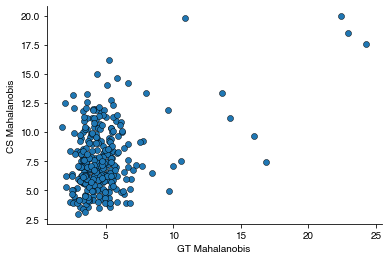

In [28]:
fig = sns.scatterplot(data.gt_mahalanobis,data.cs_mahalanobis,edgecolor='black')
plt.xlabel("GT Mahalanobis")
plt.ylabel("CS Mahalanobis")
right_side = fig.spines["right"]
right_side.set_visible(False)
top_side = fig.spines["top"]
top_side.set_visible(False)
plt.savefig("scatter_plots/CS_run2_4x5r_gt_mahala_vs_cs_mahala.pdf")

/opt/miniconda3/envs/drug_opt/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


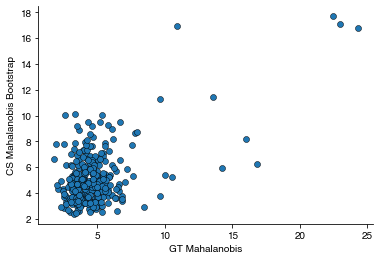

In [29]:
fig = sns.scatterplot(data.gt_mahalanobis,data.cs_mahalanobis_bootstrap,edgecolor='black')
plt.xlabel("GT Mahalanobis")
plt.ylabel("CS Mahalanobis Bootstrap")
right_side = fig.spines["right"]
right_side.set_visible(False)
top_side = fig.spines["top"]
top_side.set_visible(False)
plt.savefig("scatter_plots/CS_run2_4x5r_gt_mahala_vs_cs_mahala_boot.pdf")

/opt/miniconda3/envs/drug_opt/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


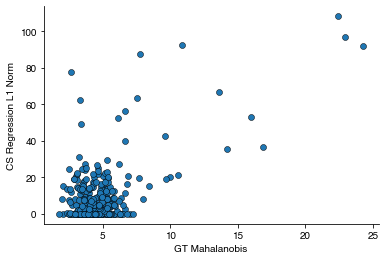

In [30]:
fig = sns.scatterplot(data.gt_mahalanobis,data.regression_l1_norm,edgecolor='black')
plt.xlabel("GT Mahalanobis")
plt.ylabel("CS Regression L1 Norm")
right_side = fig.spines["right"]
right_side.set_visible(False)
top_side = fig.spines["top"]
top_side.set_visible(False)
plt.savefig("scatter_plots/CS_run2_4x5r_gt_mahala_vs_cs_reg.pdf")

In [26]:
data

,Metadata_perturbation,gt_mahalanobis,gt_signif_mahala,gt_mahalanobis_topnum_gt_sig,gt_mahalanobis_top32,gt_mahalanobis_top5,gt_mahalanobis_top10,cs_mahalanobis,cs_signif_mahala,cs_mahalanobis_topnum_gt_sig,...,cs_mahalanobis_bootstrap_top10,regression_l1_norm,regression_l1_norm_topnum_gt_sig,regression_l1_norm_top32,regression_l1_norm_top10,regression_l1_norm_top5,Metadata_run,Metadata_compression,Metadata_replicates,Metadata_optimization
3476,(S)-Timolol Maleate,3.103113,False,False,False,False,False,3.550084,False,False,...,False,14.781662,True,False,False,False,CS_run2,4.0,5.0,random
3477,(±) Isoproterenol,4.065670,False,False,False,False,False,5.142035,True,False,...,False,17.442098,True,False,False,False,CS_run2,4.0,5.0,random
3478,(±)-Atenolol,5.288131,True,True,False,False,False,4.662718,False,False,...,False,0.000000,False,False,False,False,CS_run2,4.0,5.0,random
3479,4-Aminosalicylic Acid,4.159354,False,False,False,False,False,6.721144,True,False,...,False,0.000000,False,False,False,False,CS_run2,4.0,5.0,random
3480,Acetylcholine Chloride,5.495628,True,True,False,False,False,5.724300,True,False,...,False,6.540094,False,False,False,False,CS_run2,4.0,5.0,random
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3787,Zidovudine (3'-Azido-3'-Deoxythymidine),5.124302,True,True,False,False,False,14.616915,True,True,...,False,5.093698,False,False,False,False,CS_run2,4.0,5.0,random
3788,Zileuton,3.065881,False,False,False,False,False,7.121919,True,False,...,False,0.000000,False,False,False,False,CS_run2,4.0,5.0,random
3789,Zoledronic Acid Monohydrate,5.115475,True,True,False,False,False,8.776047,True,True,...,False,0.000000,False,False,False,False,CS_run2,4.0,5.0,random
3790,Zolmitriptan,5.136318,True,True,False,False,False,8.522851,True,True,...,False,17.432754,True,False,False,False,CS_run2,4.0,5.0,random
